# Dueling DQN - Corridor Environment Experiment
* 논문 보는 곳 : https://arxiv.org/abs/1511.06581
* Dueling architecture의 policy evaluation 퍼포먼스를 실험한 결과인 <code>Figure 3</code>를 실습해봅시다.
  
  
* 논문에서 진행한 실험 세팅과 같지 않는 점  
    1. epsilon 값이 **0.01**입니다. 0.001로 설정하면 액션을 골고루 시행할 수 있는 기회가 적어 일부 Q(s, a)의 학습(update)이 이루어지지 않습니다.
    2. <code>Figure 3</code>의 y값이 **mean squared error**입니다. 저자들이 정확히 어떻게 실험을 했는지 알 수 없지만, Q(s, a)를 아무리 학습시켜도 squared error가 <code>10^0</code>에 수렴할만큼 정확한 policy evaluaion을 하기 어려웠습니다.
    3. 종료 상태를 제외한 상태에선 **-1**의 보상을 받습니다. 즉, 최단경로로 이동하는 것을 목표로 합니다.

## 1. Import Library

In [19]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # 라이브러리들끼리 충돌을 일으켜서 matplotlib plot할 때 커널이 죽는 것을 방지

## 2. 하이퍼파라미터 세팅

In [20]:
learning_rate = 0.0001
epsilon = 0.01
action_num = 10

In [21]:
exact_q_table = None

## 3. MDP Planning by Dynamic Programming
* Policy에 대한 exact Q(s, a), 즉 Q*(s, a)를 구하기 위해 다이나믹 프로그래밍으로 MDP를 풉니다.

In [22]:
def is_state(x, y):
    if y == 0 and (9 <= x <= 18):
        return True
    elif x == 9 and (0 <= y <= 49):
        return True
    elif y == 49 and (0 <= x <= 9):
        return True
    else:
        return False
    
def is_terminal(x, y):
    if x == 18 and y == 0:
        return True
    elif x == 0 and y == 49:
        return True
    else:
        return False

In [23]:
def solve_MDP():
    # 0 : 오른쪽, 1 : 왼쪽, 2 : 아래, 3 : 위, 4~ : no-op
    dx = [0, 0, 1, -1]
    dy = [1, -1, 0, 0]    
    dx += [0]*(action_num-4)
    dy += [0]*(action_num-4)

    for repeat in range(0, 5000):
        for x in range(0, 19):
            for y in range(0, 50):
                if is_terminal(x, y) == True:
                    continue
                if is_state(x, y) == True:
                    for a in range(0, action_num):
                        reward = -1
                        if x == 17 and y == 0 and a == 2:
                            reward = 10
                        elif x == 1 and y == 49 and a == 3:
                            reward = 100

                        next_state_value = 0
                            
                        next_x = x + dx[a]
                        next_y = y + dy[a]

                        # 갈 수 없다면 제자리로 돌아오게 된다.
                        if is_state(next_x, next_y) == False:
                            next_x, next_y = x, y

                        greedy_action = np.argmax(exact_q_table[next_x, next_y, :])

                        for a_ in range(0, action_num):
                            probability = 1 - epsilon + (epsilon/action_num) if a_ == greedy_action else epsilon/action_num
                            next_state_value += (probability*exact_q_table[next_x, next_y, a_])

                        exact_q_table[x, y, a] = reward + next_state_value

## 2. Policy Evaluation by Single/Dueling Architecture
* epsilon-greedy 행동 정책에 대한 policy evaluaion을 수행합니다.

### 2.1 Corridor Environment : 논문과 동일합니다.

In [24]:
class Corridor():
    def __init__(self):
        self.x = 17
        self.y = 0
    
    def step(self, a):
        if a==0:
            self.move_right()
        elif a==1:
            self.move_left()
        elif a==2:
            self.move_down()
        elif a==3:
            self.move_up()
        else:
            self.no_op()

        reward = -1
        if self.x == 18 and self.y == 0:
            reward = 10
        elif self.x == 0 and self.y == 49:
            reward = 100
            
        done = self.is_done()
        return self.x, self.y, reward, done

    def move_right(self):
        self.y += 1  
        if is_state(self.x, self.y) == False:
            self.y -= 1
      
    def move_left(self):
        self.y -= 1
        if is_state(self.x, self.y) == False:
            self.y += 1
      
    def move_up(self):
        self.x -= 1
        if is_state(self.x, self.y) == False:
            self.x += 1
  
    def move_down(self):
        self.x += 1
        if is_state(self.x, self.y) == False:
            self.x -= 1
            
    def no_op(self):
        pass

    def is_done(self):
        if self.x == 18 and self.y == 0:
            return True
        elif self.x == 0 and self.y == 49:
            return True
        else:
            return False
      
    def reset(self):
        self.x = 17
        self.y = 0
        return (self.x, self.y)

### 2.2 Single Q-network Architecture

In [25]:
class Single_Qnet(nn.Module):
    def __init__(self):
        super(Single_Qnet, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, action_num)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
    def sample_action(self, x, y):
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,action_num-1)
        else:
            # 논문에 적혀있는 것과 마찬가지로, Optimal Q*(s, a)에서 argmax를 취합니다.
            return np.argmax(exact_q_table[x, y, :])

### 2.3 Dueling Q-network Architecture

In [26]:
class Dueling_Qnet(nn.Module):
    def __init__(self):
        super(Dueling_Qnet, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.value_fc2 = nn.Linear(50, 25)
        self.value_fc3 = nn.Linear(25, 1)
        self.advantage_fc2 = nn.Linear(50, 25)
        self.advantage_fc3 = nn.Linear(25, action_num)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        
        state_value = F.relu(self.value_fc2(x))
        state_value = self.value_fc3(state_value)
        
        advantage = F.relu(self.advantage_fc2(x))
        advantage = self.advantage_fc3(advantage)
        
        q = state_value.repeat(action_num) + (advantage - torch.mean(advantage))
        return q
      
    def sample_action(self, x, y):
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,action_num-1)
        else:
            # 논문에 적혀있는 것과 마찬가지로, Optimal Q*(s, a)에서 argmax를 취합니다.
            return np.argmax(exact_q_table[x, y, :])

### 2.3 <code>Figure 3</code> Graphing

In [27]:
def graph_Figure3(x_list, y_list, mode):
    #set_matplotlib_formats('svg')
    
    plt.rcParams['figure.dpi'] = 120
    plt.rcParams['savefig.dpi'] = 120

    plt.xlabel('Episodes', fontsize=12)
    plt.ylabel('MSE', fontsize=12)

    plt.xscale('log')
    plt.yscale('log')
    
    plt.plot(x_list, y_list, linewidth=1.5, label=mode)
    plt.xticks([10**i for i in range(3, 5)])
    plt.yticks([10**i for i in range(0, 4)])
    plt.title(f"{action_num} Action", fontsize=18)
    plt.legend()
    
    if mode == "Duel":
        plt.savefig(f"figure {action_num}.png", bbox_inches='tight')
        plt.show();

### 2.4 Main

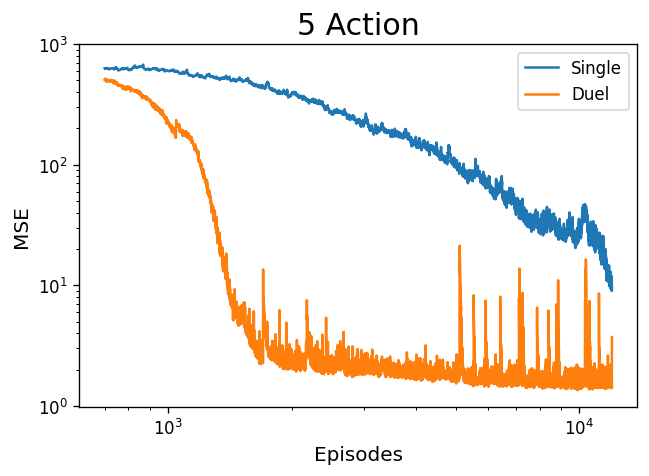

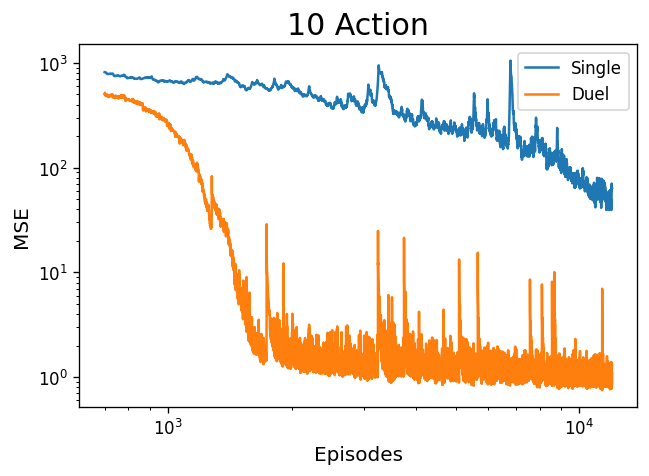

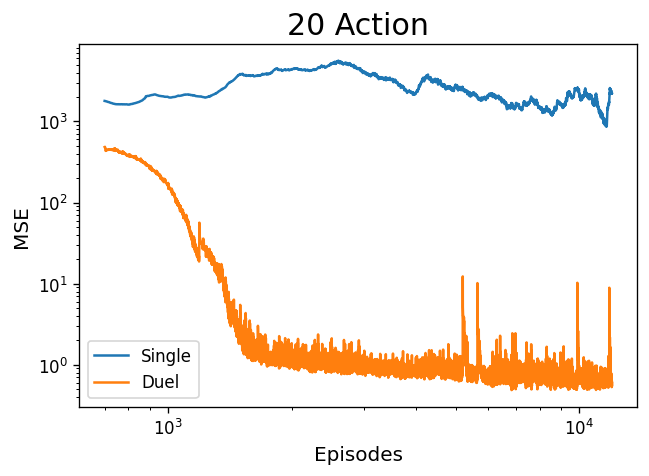

In [28]:
def main(mode):
    x_list = []
    y_list = []
    
    env = Corridor()
    q = Dueling_Qnet() if mode=="Duel" else Single_Qnet()
    score = 0.0  
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)
    
    for n_epi in range(1, 12001):
        x, y = env.reset()
        done = False
        reward = 0
        
        while not done:
            state = torch.tensor([x, y], dtype=torch.float)
            a = q.sample_action(x, y)
            nxt_x, nxt_y, r, done = env.step(a)
            nxt_state = torch.tensor([nxt_x, nxt_y], dtype=torch.float)
            done_mask = 0.0 if done else 1.0
            
            q_out = q(state)
            q_a = q_out.gather(0, torch.tensor(a))
            
            q_prime_out = q(nxt_state)
            next_greedy_action = np.argmax(exact_q_table[nxt_x, nxt_y, :])
            
            mean_q_prime = 0
            for a_ in range(0, action_num):
                probability = 1 - epsilon + (epsilon/action_num) if a_ == next_greedy_action else epsilon/action_num
                mean_q_prime += (probability*q_prime_out.gather(0, torch.tensor(a_)))
            
            target = r + mean_q_prime*done_mask
            
            loss = F.mse_loss(q_a, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            x, y = nxt_x, nxt_y

            score += r
            reward += r
            if done:
                break
                
        se = 0
        if n_epi >= 700:
            for row in range(0, 19):
                for col in range(0, 50):
                    if is_state(row, col) == True and is_terminal(row, col) == False:
                        state = torch.tensor([row, col], dtype=torch.float)
                        se += np.sum((q(state).cpu().detach().numpy() - exact_q_table[row, col, :])**2)
            x_list += [n_epi]
            y_list += [se/(68*action_num)] # mse
        
    graph_Figure3(x_list, y_list, mode)
            

            
if __name__ == '__main__':
    global action_num, exact_q_table
    for size in [5, 10, 20]:
        action_num = size
        exact_q_table = np.zeros((19, 50, action_num))
        solve_MDP()
        main("Single")
        main("Duel")